# Flag alerts

Given a set of stops, add flags to indicate which have been canceled/modified in advance.


In [1]:
# imports 

import boto3
import os
import pandas as pd
import zipfile
import requests
import pendulum
from io import BytesIO
import shapely
import geopandas

In [2]:
# if "private", will assume you have write permissions and allow you to write; else will not attempt to write files
BUCKET_TYPE = "private"

In [3]:
# Pull in static data
trips_scheduled = pd.read_parquet(f's3://rtd-ghost-buses-{BUCKET_TYPE}/schedules/trips_scheduled.parquet')
stops_scheduled = pd.read_parquet(f's3://rtd-ghost-buses-{BUCKET_TYPE}/schedules/stops_scheduled.parquet')


In [4]:
trips_scheduled.head()

,block_id,route_id,direction_id,trip_headsign,shape_id,service_id,trip_id,scheduled_service_date
0,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-05-29 00:00:00-06:00
1,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-07-04 00:00:00-06:00
2,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-05-28 00:00:00-06:00
3,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-06-04 00:00:00-06:00
4,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-06-11 00:00:00-06:00


In [5]:
stops_scheduled.head()

,block_id,route_id,direction_id,trip_headsign,shape_id,service_id,trip_id,service_date,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,arrival_datetime,departure_datetime
0,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-05-29 00:00:00-06:00,08:22:00,08:22:00,24858,1,None,None,1,None,None,2023-05-29 08:22:00-06:00,2023-05-29 08:22:00-06:00
1,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-05-29 00:00:00-06:00,08:22:45,08:22:45,25312,2,None,None,None,None,None,2023-05-29 08:22:45-06:00,2023-05-29 08:22:45-06:00
2,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-05-29 00:00:00-06:00,08:23:40,08:23:40,17023,3,None,None,None,None,None,2023-05-29 08:23:40-06:00,2023-05-29 08:23:40-06:00
3,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-05-29 00:00:00-06:00,08:24:24,08:24:24,17025,4,None,None,None,None,None,2023-05-29 08:24:24-06:00,2023-05-29 08:24:24-06:00
4,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-05-29 00:00:00-06:00,08:25:08,08:25:08,16946,5,None,None,None,None,None,2023-05-29 08:25:08-06:00,2023-05-29 08:25:08-06:00


In [6]:
# Pull in rt alerts data - whole folder
alerts_df = pd.read_parquet(f's3://rtd-ghost-buses-{BUCKET_TYPE}/processed/Alerts/')

In [7]:

alerts_df['alert.effect'].value_counts()
# NO_SERVICE            1334432
# DETOUR                 345271
# MODIFIED_SERVICE        76232
# UNKNOWN_EFFECT          72809
# OTHER_EFFECT            43167
# ADDITIONAL_SERVICE         44


NO_SERVICE            1627037
DETOUR                 516990
UNKNOWN_EFFECT          98974
MODIFIED_SERVICE        91023
OTHER_EFFECT            69710
ADDITIONAL_SERVICE         44
Name: alert.effect, dtype: int64

In [8]:
alerts_df.head()

,id,alert.activePeriod,alert.informedEntity,alert.cause,alert.effect,alert.headerText.translation,alert.descriptionText.translation,header.timestamp,filename
0,29112,"[{'end': '1672564020', 'start': '1672535580'}]","[{'agencyId': 'RTD', 'routeId': '103W', 'route...",OTHER_CAUSE,NO_SERVICE,"[{'language': 'en', 'text': 'W Line Trip 6:13 ...","[{'language': 'en', 'text': 'Affected trips: ...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...
0,29106,"[{'end': '1672566420', 'start': '1672544520'}]","[{'agencyId': 'RTD', 'routeId': '43', 'routeTy...",OTHER_CAUSE,NO_SERVICE,"[{'language': 'en', 'text': 'Route 43 Trip 8:4...","[{'language': 'en', 'text': 'Affected trips: ...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...
0,22731,"[{'end': '1680253140', 'start': '1657875600'}]","[{'agencyId': 'RTD', 'routeId': '21', 'routeTy...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...
0,29039,"[{'end': '1672567140', 'start': '1672480800'}]","[{'agencyId': 'RTD', 'routeId': '101D', 'route...",OTHER_CAUSE,MODIFIED_SERVICE,"[{'language': 'en', 'text': 'Planned schedule ...","[{'language': 'en', 'text': 'Following are fin...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...
0,29120,"[{'end': '1672562040', 'start': '1672556220'}]","[{'agencyId': 'RTD', 'routeId': 'A', 'routeTyp...",POLICE_ACTIVITY,NO_SERVICE,"[{'language': 'en', 'text': 'A Line Trip 11:57...","[{'language': 'en', 'text': 'Affected directio...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...


In [9]:
print(len(alerts_df['id'].unique()))
# alerts_df.loc[alerts_df['id']=='29112'] #['alert.informedEntity']

5273


In [10]:
# Dedupe by id, order by header_timestamp ascending
alerts_deduped_df = alerts_df.sort_values(['id', 'header.timestamp']).groupby('id').first().reset_index()
alerts_deduped_df.head()

,id,alert.activePeriod,alert.informedEntity,alert.cause,alert.effect,alert.headerText.translation,alert.descriptionText.translation,header.timestamp,filename
0,11196,"[{'end': None, 'start': '1627290000'}]","[{'agencyId': 'RTD', 'routeId': '121', 'routeT...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...
1,12906,"[{'end': None, 'start': '1634823920'}]","[{'agencyId': 'RTD', 'routeId': '52', 'routeTy...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...
2,13300,"[{'end': None, 'start': '1636624800'}]","[{'agencyId': 'RTD', 'routeId': '52', 'routeTy...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...
3,15312,"[{'end': None, 'start': '1641917760'}]","[{'agencyId': 'RTD', 'routeId': '15', 'routeTy...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...
4,15372,"[{'end': '1690880340', 'start': '1643104800'}]","[{'agencyId': 'RTD', 'routeId': '225', 'routeT...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...


In [11]:
print(alerts_deduped_df['alert.informedEntity'].apply(len))
print(alerts_deduped_df['alert.activePeriod'].apply(len).value_counts()) # There's one example with 6 activePeriod items in the list! Forget it, take first in list without guilt.
print(alerts_deduped_df['alert.headerText.translation'].apply(len).value_counts())
print(alerts_deduped_df['alert.descriptionText.translation'].apply(len).value_counts())


0       1
1       1
2       1
3       1
4       6
       ..
5268    1
5269    1
5270    1
5271    1
5272    6
Name: alert.informedEntity, Length: 5273, dtype: int64
1    5272
6       1
Name: alert.activePeriod, dtype: int64
1    5273
Name: alert.headerText.translation, dtype: int64
1    5273
Name: alert.descriptionText.translation, dtype: int64


In [12]:

# Case study
print(alerts_deduped_df.iloc[4342]) #['alert.informedEntity']

print(alerts_deduped_df.iloc[4342]['alert.informedEntity']) 
print(alerts_deduped_df.iloc[4342]['alert.headerText.translation'])
print(alerts_deduped_df.iloc[4342]['alert.descriptionText.translation'])#
# 4342

id                                                                               33507
alert.activePeriod                      [{'end': '1683010260', 'start': '1682975580'}]
alert.informedEntity                 [{'agencyId': 'RTD', 'routeId': '101D', 'route...
alert.cause                                                                OTHER_CAUSE
alert.effect                                                                NO_SERVICE
alert.headerText.translation         [{'language': 'en', 'text': 'D Line Trip 3:13 ...
alert.descriptionText.translation    [{'language': 'en', 'text': 'Affected trips:
...
header.timestamp                                                   2023-05-01 19:17:40
filename                             bus_data_Alerts/2023-05-01T13:18:11.880562-06:...
Name: 4342, dtype: object
[{'agencyId': 'RTD', 'routeId': '101D', 'routeType': 0, 'stopId': None, 'trip': {'tripId': '114368717'}}
 {'agencyId': 'RTD', 'routeId': '101D', 'routeType': 0, 'stopId': None, 'trip': {'tripI

(105,)
(82,)
False    5250
True       23
Name: alert_end, dtype: int64


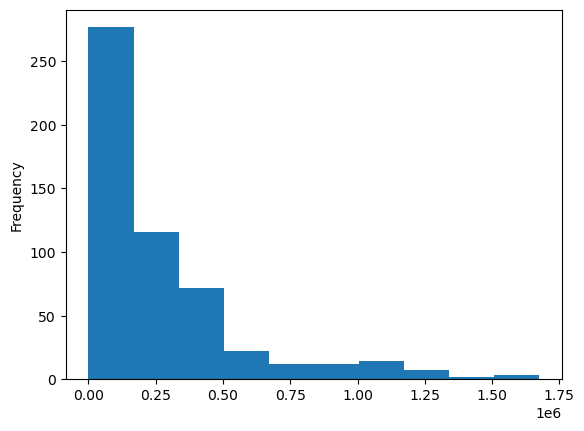

In [13]:
# Unwrap - get start and end
# TODO - prod code
alerts_deduped_df['alert_start'] = pd.to_datetime(alerts_deduped_df['alert.activePeriod'].apply(lambda x: x[0]['start']),unit='s', utc=True)
alerts_deduped_df['alert_end'] = pd.to_datetime(alerts_deduped_df['alert.activePeriod'].apply(lambda x: x[0]['end']),unit='s', utc=True)
# alerts_deduped_df['alert_end'] = pd.to_datetime(alerts_deduped_df['alert_end'])
# Advance notice of alert: Timedelta between header.timestamp in deduped (sorted) and alert_start
alerts_deduped_df['header.timestamp'] = alerts_deduped_df['header.timestamp'].dt.tz_localize('America/Denver') # Only run once
alerts_deduped_df['advance_notice'] = alerts_deduped_df['alert_start'] - alerts_deduped_df['header.timestamp']
alerts_deduped_df['advance_notice'].sort_values() # Handful of negatives. Long-running before data collection? # Not Code
# alerts_deduped_df['advance_notice'].plot(kind='hist')
alerts_deduped_df.iloc[4344] # Not Code
alerts_deduped_df.loc[alerts_deduped_df['advance_notice'] >= pd.Timedelta(-1,'s'),'advance_notice'].dt.total_seconds().plot.hist() # # Not Code

# Fill in end date with max(header.timestamp) when end is empty & max(header.timestamp) for those rows is *not* the max across alerts_df (indicating that it's still ongoing)
no_end_list = alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()]['id'].tolist()
end_fill_df = alerts_df.loc[alerts_df['id'].isin(no_end_list)].groupby('id')['header.timestamp'].max()
print(end_fill_df.shape) # Not Code
end_fill_df = end_fill_df.loc[end_fill_df < alerts_df['header.timestamp'].max()]
end_fill_df.name = 'alert_end' # Rename to successfully use update later
print(end_fill_df.shape) # Not Code - 19 still ongoing as of May 1-ish
alerts_deduped_df2 = alerts_deduped_df.set_index('id')
alerts_deduped_df2.update(end_fill_df.dt.tz_localize('America/Denver'))
alerts_deduped_df2['alert_end'] = pd.to_datetime(alerts_deduped_df2['alert_end'], utc=True) # Have to re-cast type after update

print(alerts_deduped_df2['alert_end'].isna().value_counts()) # Not Code

alerts_deduped_df = alerts_deduped_df2.reset_index()
# alerts_deduped_df2.index

In [14]:
# TODO Code to extract affected stops + trips
alerts_deduped_df.head()
# alerts_deduped_df['alert.informedEntity'].iloc[50][0] # For a given row, list of dicts with routeId:/stopId:/trip:{tripId:<string of trip id>)
alerts_deduped_df['affected_stops_list'] = alerts_deduped_df['alert.informedEntity'].apply(lambda x: [d['stopId'] for d in x]) # Stop Id's are all lists
alerts_deduped_df['affected_routes_list'] = alerts_deduped_df['alert.informedEntity'].apply(lambda x: [d['routeId'] for d in x])
alerts_deduped_df['affected_trips_list'] = alerts_deduped_df['alert.informedEntity'].apply(lambda x: [d['trip']['tripId'] for d in x if d['trip'] is not None] ) # Note, all ints
# alerts_deduped_df['alert.effect'].value_counts()
# ['NO_SERVICE', 'DETOUR', 'MODIFIED_SERVICE'] # Use these categories in alert.effect to flag reduced service 


In [15]:
alerts_deduped_df.head()

,id,alert.activePeriod,alert.informedEntity,alert.cause,alert.effect,alert.headerText.translation,alert.descriptionText.translation,header.timestamp,filename,alert_start,alert_end,advance_notice,affected_stops_list,affected_routes_list,affected_trips_list
0,11196,"[{'end': None, 'start': '1627290000'}]","[{'agencyId': 'RTD', 'routeId': '121', 'routeT...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55-07:00,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...,2021-07-26 09:00:00+00:00,NaT,-525 days +18:58:05,[15922],[121],[]
1,12906,"[{'end': None, 'start': '1634823920'}]","[{'agencyId': 'RTD', 'routeId': '52', 'routeTy...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55-07:00,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...,2021-10-21 13:45:20+00:00,NaT,-438 days +23:43:25,[12319],[52],[]
2,13300,"[{'end': None, 'start': '1636624800'}]","[{'agencyId': 'RTD', 'routeId': '52', 'routeTy...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55-07:00,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...,2021-11-11 10:00:00+00:00,NaT,-417 days +19:58:05,[12318],[52],[]
3,15312,"[{'end': None, 'start': '1641917760'}]","[{'agencyId': 'RTD', 'routeId': '15', 'routeTy...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55-07:00,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...,2022-01-11 16:16:00+00:00,NaT,-355 days +02:14:05,[35399],[15],[]
4,15372,"[{'end': '1690880340', 'start': '1643104800'}]","[{'agencyId': 'RTD', 'routeId': '225', 'routeT...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55-07:00,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...,2022-01-25 10:00:00+00:00,2023-08-01 08:59:00+00:00,-342 days +19:58:05,"[12609, 12609, 12609, 12609, 12609, 12609]","[225, 225D, 225T, DASH, SKIP, 204]",[]


In [16]:
# TODO Code to apply these to the trips_scheduled / stops_scheduled datasets
# merge between stop and end
 #Can also try pandasql, but this supposedly has better performance

# Create dataframes with start time/stop time/affected (route/trip/stop)
# One dataframe per kind
# Drop duplicates to cover for cases where the alerts repeat the same info

alerts_deduped_df['affected_stops_list'].explode() # index is numeric index, not alert id.
alerts_cols = ['id','alert_start', 'alert_end','advance_notice','alert.cause', 'alert.effect']
affected_stops_df = alerts_deduped_df[alerts_cols].merge(alerts_deduped_df['affected_stops_list'].explode(), left_index = True, right_index = True)
affected_stops_df['affected_stops_list'] = affected_stops_df['affected_stops_list'].astype(str)
affected_stops_df = affected_stops_df.drop_duplicates()

affected_trips_df = alerts_deduped_df[alerts_cols].merge(alerts_deduped_df['affected_trips_list'].explode(), left_index = True, right_index = True)
affected_trips_df['affected_trips_list'] = affected_trips_df['affected_trips_list'].astype(str)
affected_stops_df = affected_stops_df.drop_duplicates()

affected_routes_df = alerts_deduped_df[alerts_cols].merge(alerts_deduped_df['affected_routes_list'].explode(), left_index = True, right_index = True)
affected_routes_df['affected_routes_list'] = affected_routes_df['affected_routes_list'].astype(str)
affected_routes_df = affected_routes_df.drop_duplicates()


In [17]:
# Add flag by first converting to something I can run a sql query on:
# Convert to relations 
import duckdb

# trips_scheduled_duck = duckdb.query(
#     "SELECT * FROM trips_scheduled"
# ).to_df() # 1 second
# stops_scheduled_duck = duckdb.query(
#     "SELECT * FROM stops_scheduled limit 10000"
# ).to_df() # More seconds
# # stops_scheduled_duck = duckdb.query(
# #     "SELECT * FROM stops_scheduled"
# # ).to_df() # More seconds. But only like ~8 minutes!
# affected_stops_duck = duckdb.query("SELECT * FROM affected_stops_df").to_df()
# affected_trips_duck = duckdb.query("SELECT * FROM affected_trips_df").to_df()
# affected_routes_duck = duckdb.query("SELECT * FROM affected_routes_df").to_df()



In [18]:
# relational version:
# 10 seconds to do a big merge and filter on start and end times!
# Prod code:
con = duckdb.connect()
con.execute("SET GLOBAL pandas_analyze_sample=100000") # Necessary to avoid typing errors. Or specify manually.
trips_scheduled_rel = con.from_df(trips_scheduled).set_alias('trips_scheduled_rel')
# stops_scheduled_rel = con.from_df(stops_scheduled[:10000]).set_alias('stops_scheduled_rel')
stops_scheduled_rel = con.from_df(stops_scheduled.reset_index()).set_alias('stops_scheduled_rel')
affected_stops_rel = con.from_df(affected_stops_df).set_alias('affected_stops_rel')
affected_trips_rel = con.from_df(affected_trips_df).set_alias('affected_trips_rel')
affected_routes_rel = con.from_df(affected_routes_df).set_alias('affected_routes_rel')

# Get affected stops/trips/routes

# stops_scheduled_rel.join(affected_stops_rel,'stops_scheduled_rel.stop_id = affected_stops_rel.affected_stops_list',how = 'left').filter('affected_stops_rel.alert_start < stops_scheduled_rel.departure_datetime').filter('affected_stops_rel.alert_end > stops_scheduled_rel.departure_datetime').show() #
# print(stops_scheduled_affected_stops_df.shape)
# print(stops_scheduled_affected_stops_df.head() )

stops_scheduled_affected_stops_df = stops_scheduled_rel.join(affected_stops_rel,'stops_scheduled_rel.stop_id = affected_stops_rel.affected_stops_list',how = 'left').filter('affected_stops_rel.alert_start < stops_scheduled_rel.departure_datetime').filter('affected_stops_rel.alert_end > stops_scheduled_rel.departure_datetime').df()
stops_scheduled_affected_trips_df = stops_scheduled_rel.join(affected_trips_rel,'stops_scheduled_rel.trip_id = affected_trips_rel.affected_trips_list',how = 'left').filter('affected_trips_rel.alert_start < stops_scheduled_rel.departure_datetime').filter('affected_trips_rel.alert_end > stops_scheduled_rel.departure_datetime').df()
stops_scheduled_affected_routes_df = stops_scheduled_rel.join(affected_routes_rel,'stops_scheduled_rel.route_id = affected_routes_rel.affected_routes_list',how = 'left').filter('affected_routes_rel.alert_start < stops_scheduled_rel.departure_datetime').filter('affected_routes_rel.alert_end > stops_scheduled_rel.departure_datetime').df()
# stops_scheduled_df = stops_scheduled_rel.df() # Do I need this?

# Actually, I can optimize this too! # TODO
print(stops_scheduled_affected_stops_df.shape)
print(stops_scheduled_affected_trips_df.shape)
print(stops_scheduled_affected_routes_df.shape)
stops_scheduled_affected_stops_df = stops_scheduled_affected_stops_df.sort_values('advance_notice', ascending = False).drop_duplicates('index')
stops_scheduled_affected_trips_df = stops_scheduled_affected_trips_df.sort_values('advance_notice', ascending = False).drop_duplicates('index')
stops_scheduled_affected_routes_df = stops_scheduled_affected_routes_df.sort_values('advance_notice', ascending = False).drop_duplicates('index')
print(stops_scheduled_affected_stops_df.shape)
print(stops_scheduled_affected_trips_df.shape)
print(stops_scheduled_affected_routes_df.shape)


# Finally, do one merge back to 

# output_df = transformed_rel.from_df()
con.close()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [22]:
# Take alert with the most advanced notice
# Has small risk of missing different reasons but, most alerts do 

# print(stops_scheduled_affected_stops_df.shape)
# print(stops_scheduled_affected_trips_df.shape)
# print(stops_scheduled_affected_routes_df.shape)
# stops_scheduled_affected_stops_df = stops_scheduled_affected_stops_df.sort_values('advance_notice', ascending = False).drop_duplicates('index')
# stops_scheduled_affected_trips_df = stops_scheduled_affected_trips_df.sort_values('advance_notice', ascending = False).drop_duplicates('index')
# stops_scheduled_affected_routes_df = stops_scheduled_affected_routes_df.sort_values('advance_notice', ascending = False).drop_duplicates('index')
# print(stops_scheduled_affected_stops_df.shape)
# print(stops_scheduled_affected_trips_df.shape)
# print(stops_scheduled_affected_routes_df.shape)



## Sanity-checks


In [ ]:
# Sanity-check
print(alerts_deduped_df['alert_start'].isna().value_counts())
print(alerts_deduped_df['alert_end'].isna().value_counts())
# 90 out of 4347 are missing an end. Is that a problem?
# Potentially, yes. Look for when the alert does *not* show up anymore?

In [ ]:
alerts_deduped_df['alert_start'].sort_values()
print(alerts_deduped_df.iloc[4345])
print(alerts_deduped_df.iloc[4345]['alert.informedEntity'])
print(alerts_deduped_df.iloc[4345]['alert.headerText.translation'])
print(alerts_deduped_df.iloc[4345]['alert.descriptionText.translation'])


In [ ]:
alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[0]
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[0]['alert.informedEntity'])
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[0]['alert.headerText.translation'])
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[0]['alert.descriptionText.translation'])

In [ ]:
alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[1]
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[1]['alert.informedEntity'])
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[1]['alert.headerText.translation'])
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[1]['alert.descriptionText.translation'])

In [ ]:
alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[2]
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[2]['alert.informedEntity'])
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[2]['alert.headerText.translation'])
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[2]['alert.descriptionText.translation'])